In [1]:
!nvidia-smi

Fri Jan  7 12:23:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.client import device_lib
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import os
import seaborn as sns
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
%matplotlib inline

In [41]:
print(tf.__version__)
print(device_lib.list_local_devices())
running_env = "colab"
# running_env = "local"

2.7.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7524013923363807361
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16701123741634023375
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [42]:
if running_env == "colab":
  train_df = pd.read_csv('/content/drive/MyDrive/steel-defect-detection/input/train.csv')
else:
  train_df = pd.read_csv('steel-defect-detection/input/train.csv')

train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
train_df = train_df.groupby('ImageId')['ClassId'].apply(list).reset_index()
train_df[:6]

,ImageId,ClassId
0,0002cc93b.jpg,[1]
1,0007a71bf.jpg,[3]
2,000a4bcdd.jpg,[1]
3,000f6bf48.jpg,[4]
4,0014fce06.jpg,[3]
5,0025bde0c.jpg,"[3, 4]"


In [6]:
mlb = MultiLabelBinarizer()
data = mlb.fit_transform(train_df['ClassId'])
defects_columns = []

for column in list(mlb.classes_):
  defects_columns.append("defect_"+ str(column))

onehot_encoded_classes_df = pd.DataFrame(data, columns=defects_columns)
onehot_encoded_classes_df[:6]

,defect_1,defect_2,defect_3,defect_4
0,1,0,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,1,0
5,0,0,1,1


In [7]:
train_df = pd.concat([train_df.drop('ClassId',axis=1), onehot_encoded_classes_df], axis=1)
train_df.head()

,ImageId,defect_1,defect_2,defect_3,defect_4
0,0002cc93b.jpg,1,0,0,0
1,0007a71bf.jpg,0,0,1,0
2,000a4bcdd.jpg,1,0,0,0
3,000f6bf48.jpg,0,0,0,1
4,0014fce06.jpg,0,0,1,0


In [8]:
train_df.shape

(6666, 5)

In [43]:
if running_env == "colab":
  data_dir = '/content/drive/MyDrive/steel-defect-detection/'
else:
  data_dir = 'steel-defect-detection/'

test_path = data_dir + 'input/test_images'
train_path = data_dir + 'input/train_images'

In [10]:
steel_image = train_path + '/' + os.listdir(train_path)[0]
imread(steel_image).shape

(256, 1600, 3)

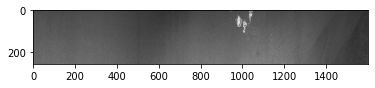

In [11]:
plt.imshow(imread(steel_image))

In [12]:
image_shape = imread(steel_image).shape
IMAGE_SIZE = list(image_shape)
inceptionv3 = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

In [13]:
for layer in inceptionv3.layers:
    layer.trainable = False

In [14]:
inception_op = Flatten()(inceptionv3.output)
prediction = Dense(4, activation='sigmoid')(inception_op)

model = Model(inputs=inceptionv3.input, outputs=prediction)
# model.summary()

In [15]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
    )

In [16]:
train_image = []

for _, image_path in zip(tqdm(range(train_df.shape[0])), os.listdir(train_path)):
    full_image_path = train_path + '/' + image_path
    img = image.load_img(full_image_path, target_size=image_shape)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)

  0%|          | 19/6666 [00:00<03:13, 34.34it/s]


(20, 256, 1600, 3)


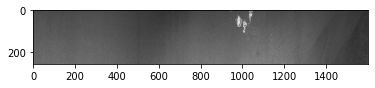

In [17]:
print(X.shape)
plt.imshow(X[0])

In [18]:
y = np.array(train_df.drop(['ImageId'], axis=1))
y.shape

(20, 4)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
trained_model = model.fit(X_train, y_train, epochs=100, 
          validation_data=(X_test, y_test), 
          batch_size=64,
          callbacks = [early_stop])

Epoch 1/2
1/1 [==============================] - 24s 24s/step - loss: 0.6786 - accuracy: 0.2222 - val_loss: 14.8794 - val_accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 1s 933ms/step - loss: 6.2644 - accuracy: 0.7222 - val_loss: 18.0197 - val_accuracy: 0.5000


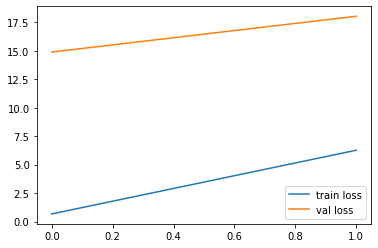

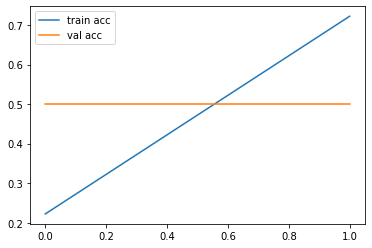

In [21]:
# plot the loss
plt.plot(trained_model.history['loss'], label='train loss')
plt.plot(trained_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(trained_model.history['accuracy'], label='train acc')
plt.plot(trained_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

defects with their probablity:
defect_2 (0.0)
defect_1 (1.62e-34)
defect_4 (9.05e-18)
defect_3 (1.0)

actual output: [0 0 1 0] 


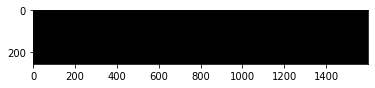

In [37]:
# Make a Prediction
img = X_train[15]/255
classes = np.array(train_df.columns[1:])
prediction_shape = tuple([1] + IMAGE_SIZE)
proba = model.predict(img.reshape(prediction_shape))
sorted_prob = np.argsort(proba[0])
print("defects with their probablity:")

for i in range(len(sorted_prob)):
    print("{}".format(classes[sorted_prob[i]])+" ({:.3})".format(proba[0][sorted_prob[i]]))

print()
plt.imshow(img)

print("actual output: {} ".format(y_train[15]))

In [23]:
model.save(data_dir+'model/inceptionv3.h5')